# Import libraries and setting up device-agnostic code

In [1]:
# General libraries
import os
import random
import optuna
import shutil
import zipfile
import pathlib
import requests
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm # tqdm for progress bar
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from timeit import default_timer as timer
from typing import Tuple, Dict, List


# torch
import torch
from torch import nn
from torchinfo import summary
from torchmetrics import Accuracy
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchmetrics.classification import BinaryConfusionMatrix, BinaryPrecision, BinaryRecall, BinaryF1Score, BinaryAccuracy

# torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import torchvision.transforms.functional as F
from torchvision.models import alexnet, vgg16

c:\Users\Sarthak\OneDrive\Desktop\DFPE\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
!nvidia-smi

Thu Dec  5 23:57:35 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 556.13                 Driver Version: 556.13         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   53C    P8              4W /  110W |     482MiB /   8188MiB |     10%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Subset Data Set

In [4]:
# Configuration
SUBSET_RATIO = 0.4

# Base paths - Using your specified path
base_dir = r"C:\Users\Sarthak\OneDrive\Desktop\Dataset"
subset_dir = r"C:\Users\Sarthak\OneDrive\Desktop\Dataset_Subset"  # Creating a new directory for subset

# Define source directories
train_dir = os.path.join(base_dir, 'Train')
test_dir = os.path.join(base_dir, 'Test')
val_dir = os.path.join(base_dir, 'Validation')

# Define destination directories
subset_train_dir = os.path.join(subset_dir, 'Train')
subset_test_dir = os.path.join(subset_dir, 'Test')
subset_val_dir = os.path.join(subset_dir, 'Validation')

def get_dataset_size(directory):
    """Calculate total number of images in a directory including subdirectories"""
    try:
        return len(list(pathlib.Path(directory).rglob("*.jpg")))
    except Exception as e:
        print(f"Error counting files in {directory}: {str(e)}")
        return 0

def copy_subset(source_dir, dest_dir, subset_ratio):
    """Copy a subset of files from source to destination directory maintaining structure"""
    # Process both Real and Fake directories
    for category in ['Real', 'Fake']:
        source_category_dir = os.path.join(source_dir, category)
        dest_category_dir = os.path.join(dest_dir, category)
        
        # Create destination category directory
        os.makedirs(dest_category_dir, exist_ok=True)
        
        # Get all jpg files in the category directory
        try:
            files = list(pathlib.Path(source_category_dir).glob("*.jpg"))
            
            if not files:
                print(f"Warning: No files found in {source_category_dir}")
                continue
                
            subset_size = max(1, int(subset_ratio * len(files)))  # Ensure at least 1 file is copied
            subset_files = random.sample(files, subset_size)
            
            print(f"Copying {subset_size} {category} files from {os.path.basename(source_dir)}...")
            
            for file_path in subset_files:
                if file_path.is_file():
                    try:
                        shutil.copy2(str(file_path), dest_category_dir)
                    except Exception as e:
                        print(f"Error copying {file_path}: {str(e)}")
                    
        except Exception as e:
            print(f"Error processing {source_category_dir}: {str(e)}")

def main():
    # Create main subset directory
    try:
        os.makedirs(subset_dir, exist_ok=True)
    except Exception as e:
        print(f"Error creating subset directory: {str(e)}")
        return

    # Print original dataset sizes
    print("\nOriginal dataset sizes:")
    train_size = get_dataset_size(train_dir)
    test_size = get_dataset_size(test_dir)
    val_size = get_dataset_size(val_dir)
    print(f"Train: {train_size} images")
    print(f"Test: {test_size} images")
    print(f"Validation: {val_size} images")
    
    # Create and copy subsets
    for source, dest in [
        (train_dir, subset_train_dir),
        (test_dir, subset_test_dir),
        (val_dir, subset_val_dir)
    ]:
        print(f"\nProcessing {os.path.basename(source)} directory...")
        copy_subset(source, dest, SUBSET_RATIO)
    
    # Print final subset sizes
    print("\nSubset dataset sizes:")
    print(f"Train: {get_dataset_size(subset_train_dir)} images")
    print(f"Test: {get_dataset_size(subset_test_dir)} images")
    print(f"Validation: {get_dataset_size(subset_val_dir)} images")

if __name__ == "__main__":
    main()


Original dataset sizes:
Train: 140002 images
Test: 10905 images
Validation: 39428 images

Processing Train directory...
Copying 28000 Real files from Train...
Copying 28000 Fake files from Train...

Processing Test directory...
Copying 2165 Real files from Test...
Copying 2196 Fake files from Test...

Processing Validation directory...
Copying 7914 Real files from Validation...
Copying 7856 Fake files from Validation...

Subset dataset sizes:
Train: 133782 images
Test: 10270 images
Validation: 36280 images


# 1. Get dataset

In [5]:
# Setup path to data folder
data_path = Path(r"C:\Users\Sarthak\OneDrive\Desktop")
base_dir = data_path / "Dataset"

In [6]:
def walk_through_dir(dir_path):
    """Walks through dir_path returning its contents."""
    total_images = 0
    for dirpath, dirnames, filenames in os.walk(dir_path):
        image_files = [f for f in filenames if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        print(f"There are {len(dirnames)} directories and {len(image_files)} images in '{dirpath}'.")
        total_images += len(image_files)
    print(f"\nTotal number of images found: {total_images}")

In [7]:
# Print directory structure
print("Analyzing dataset structure...")
walk_through_dir(base_dir)

Analyzing dataset structure...
There are 3 directories and 0 images in 'C:\Users\Sarthak\OneDrive\Desktop\Dataset'.
There are 2 directories and 0 images in 'C:\Users\Sarthak\OneDrive\Desktop\Dataset\Test'.
There are 0 directories and 5492 images in 'C:\Users\Sarthak\OneDrive\Desktop\Dataset\Test\Fake'.
There are 0 directories and 5413 images in 'C:\Users\Sarthak\OneDrive\Desktop\Dataset\Test\Real'.
There are 2 directories and 0 images in 'C:\Users\Sarthak\OneDrive\Desktop\Dataset\Train'.
There are 0 directories and 70001 images in 'C:\Users\Sarthak\OneDrive\Desktop\Dataset\Train\Fake'.
There are 0 directories and 70001 images in 'C:\Users\Sarthak\OneDrive\Desktop\Dataset\Train\Real'.
There are 2 directories and 0 images in 'C:\Users\Sarthak\OneDrive\Desktop\Dataset\Validation'.
There are 0 directories and 19641 images in 'C:\Users\Sarthak\OneDrive\Desktop\Dataset\Validation\Fake'.
There are 0 directories and 19787 images in 'C:\Users\Sarthak\OneDrive\Desktop\Dataset\Validation\Real'.



In [8]:
# Path for train, validation and test data set
train_path = base_dir / "Train"
val_path = base_dir / "Validation"
test_path = base_dir / "Test"

# Print the paths to verify
print("\nDataset paths:")
print(f"Training data: {train_path}")
print(f"Validation data: {val_path}")
print(f"Testing data: {test_path}")

# Verify each directory exists
for path in [train_path, val_path, test_path]:
    if path.exists():
        print(f"\nAnalyzing {path.name} directory:")
        walk_through_dir(path)
    else:
        print(f"\nWarning: {path.name} directory not found at {path}")



Dataset paths:
Training data: C:\Users\Sarthak\OneDrive\Desktop\Dataset\Train
Validation data: C:\Users\Sarthak\OneDrive\Desktop\Dataset\Validation
Testing data: C:\Users\Sarthak\OneDrive\Desktop\Dataset\Test

Analyzing Train directory:
There are 2 directories and 0 images in 'C:\Users\Sarthak\OneDrive\Desktop\Dataset\Train'.
There are 0 directories and 70001 images in 'C:\Users\Sarthak\OneDrive\Desktop\Dataset\Train\Fake'.
There are 0 directories and 70001 images in 'C:\Users\Sarthak\OneDrive\Desktop\Dataset\Train\Real'.

Total number of images found: 140002

Analyzing Validation directory:
There are 2 directories and 0 images in 'C:\Users\Sarthak\OneDrive\Desktop\Dataset\Validation'.
There are 0 directories and 19641 images in 'C:\Users\Sarthak\OneDrive\Desktop\Dataset\Validation\Fake'.
There are 0 directories and 19787 images in 'C:\Users\Sarthak\OneDrive\Desktop\Dataset\Validation\Real'.

Total number of images found: 39428

Analyzing Test directory:
There are 2 directories and 0 

## 2.1 Visualizing an image

In [9]:
# Set seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(base_dir.glob(pattern="*/*/*.jpg"))

image_path_list[:10]

[WindowsPath('C:/Users/Sarthak/OneDrive/Desktop/Dataset/Test/Fake/fake_0.jpg'),
 WindowsPath('C:/Users/Sarthak/OneDrive/Desktop/Dataset/Test/Fake/fake_1.jpg'),
 WindowsPath('C:/Users/Sarthak/OneDrive/Desktop/Dataset/Test/Fake/fake_10.jpg'),
 WindowsPath('C:/Users/Sarthak/OneDrive/Desktop/Dataset/Test/Fake/fake_100.jpg'),
 WindowsPath('C:/Users/Sarthak/OneDrive/Desktop/Dataset/Test/Fake/fake_1000.jpg'),
 WindowsPath('C:/Users/Sarthak/OneDrive/Desktop/Dataset/Test/Fake/fake_1001.jpg'),
 WindowsPath('C:/Users/Sarthak/OneDrive/Desktop/Dataset/Test/Fake/fake_1002.jpg'),
 WindowsPath('C:/Users/Sarthak/OneDrive/Desktop/Dataset/Test/Fake/fake_1003.jpg'),
 WindowsPath('C:/Users/Sarthak/OneDrive/Desktop/Dataset/Test/Fake/fake_1004.jpg'),
 WindowsPath('C:/Users/Sarthak/OneDrive/Desktop/Dataset/Test/Fake/fake_1005.jpg')]

In [10]:
# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name
image_class = random_image_path.parent.stem
print(image_class)

C:\Users\Sarthak\OneDrive\Desktop\Dataset\Validation\Fake\fake_7364.jpg
Fake


Random image path: C:\Users\Sarthak\OneDrive\Desktop\Dataset\Validation\Fake\fake_7364.jpg
Image class: Fake
Image height: 256
Image width: 256


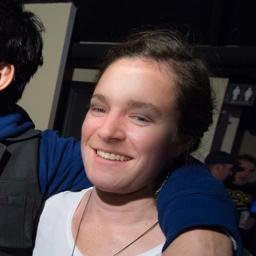

In [11]:
# 4. Open image
img = Image.open(random_image_path)

# 5. print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

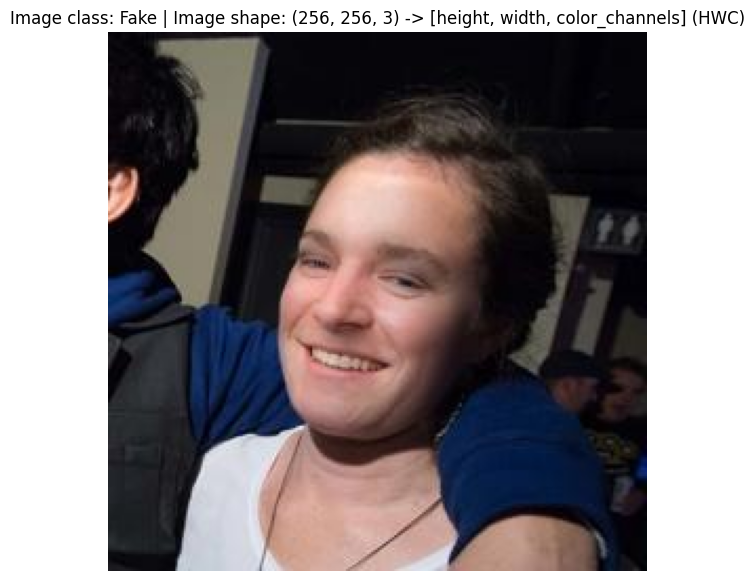

In [12]:
# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)")
plt.axis(False)
plt.show()

In [13]:
data_transform_trivial = transforms.Compose([
    # Resize to 64x64
    transforms.Resize(size=(128, 128)),
    # Randomly augment the data
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

data_transform_simple = transforms.Compose([
    # Resize to 64x64
    transforms.Resize(size=(64, 64)),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

train_data = datasets.ImageFolder(root=train_path,
                                 transform=data_transform_simple,
                                 target_transform=None)

val_data = datasets.ImageFolder(root=val_path,
                                transform=data_transform_simple,
                                target_transform=None)

test_data = datasets.ImageFolder(root=test_path,
                                transform=data_transform_simple,
                                target_transform=None)

In [14]:
print(f"Train data length     : {len(train_data)}")
print(f"Validation data length: {len(val_data)}")
print(f"Test data length      : {len(test_data)}")

Train data length     : 140002
Validation data length: 39428
Test data length      : 10905


In [15]:
class_names = train_data.classes
class_names

['Fake', 'Real']

In [16]:
class_dict = train_data.class_to_idx
class_dict

{'Fake': 0, 'Real': 1}

In [17]:
# See the first training example
image, label = train_data[0]
image, label

(tensor([[[0.6275, 0.6353, 0.6431,  ..., 0.7412, 0.7451, 0.7529],
          [0.6275, 0.6353, 0.6392,  ..., 0.7373, 0.7373, 0.7451],
          [0.6314, 0.6392, 0.6392,  ..., 0.7294, 0.7333, 0.7294],
          ...,
          [0.3804, 0.4471, 0.5216,  ..., 0.6510, 0.6510, 0.6627],
          [0.3843, 0.4353, 0.5373,  ..., 0.6627, 0.6549, 0.6471],
          [0.3765, 0.4392, 0.5059,  ..., 0.6745, 0.6627, 0.6549]],
 
         [[0.6000, 0.6078, 0.6157,  ..., 0.7216, 0.7255, 0.7333],
          [0.6000, 0.6078, 0.6118,  ..., 0.7176, 0.7176, 0.7255],
          [0.6039, 0.6118, 0.6157,  ..., 0.7098, 0.7137, 0.7098],
          ...,
          [0.3137, 0.3843, 0.4784,  ..., 0.5804, 0.5804, 0.5882],
          [0.3176, 0.3569, 0.4745,  ..., 0.5882, 0.5804, 0.5725],
          [0.3098, 0.3451, 0.4314,  ..., 0.6000, 0.5882, 0.5804]],
 
         [[0.6706, 0.6784, 0.6863,  ..., 0.7490, 0.7529, 0.7608],
          [0.6667, 0.6745, 0.6784,  ..., 0.7451, 0.7451, 0.7529],
          [0.6588, 0.6667, 0.6706,  ...,

In [18]:
# Check the shape of the image
print(f"Image shape: {image.shape} -> [color_channels, height, width]")
print(f"Image label: {class_names[label]}")

Image shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image label: Fake


## 1.1 Visualizing the dataset

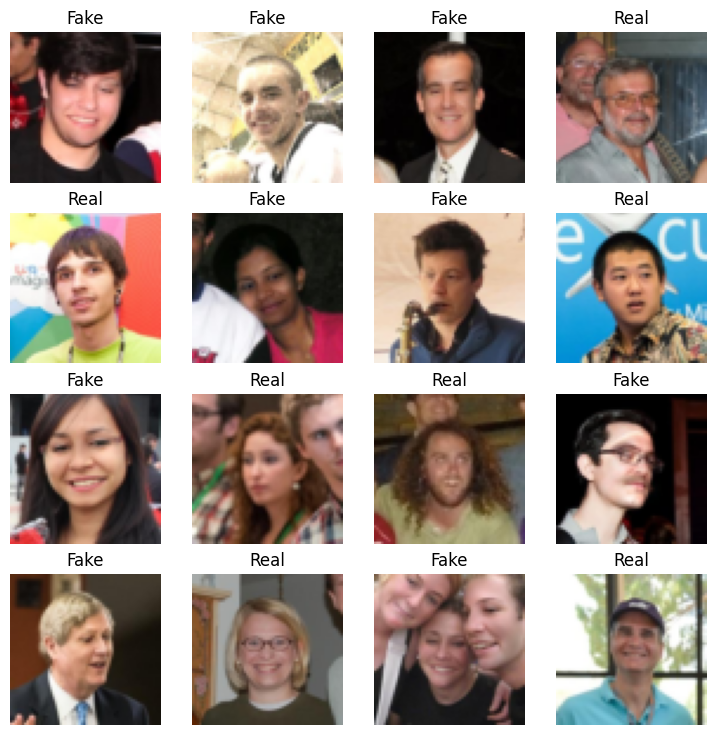

In [19]:
# Plot some random images
torch.manual_seed = 42
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    # img = img.permute(1, 2, 0)
    fig.add_subplot(rows, cols, i)
    plt.imshow(F.to_pil_image(img))
    plt.title(class_names[label])
    plt.axis(False)

# 2. Prepare Data Loader

In [20]:
# Turn train and test datasets into Dataloader'set
BATCH_SIZE=32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

val_dataloader = DataLoader(dataset=val_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

train_dataloader, test_dataloader, val_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1ab05a2e040>,
 <torch.utils.data.dataloader.DataLoader at 0x1ab05a2e580>)

In [21]:
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of val_dataloader: {len(val_dataloader)} batches of {BATCH_SIZE}...")

Length of train_dataloader: 4376 batches of 32...
Length of test_dataloader: 341 batches of 32...
Length of val_dataloader: 1233 batches of 32...


# Helper Functions

In [22]:
# time out the experience
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None) -> float:
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [23]:
# Plot loss curves
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary."""
    # Get the loss values of the results dictionary (training and test)
    loss = results["train_loss"] 
    test_loss = results["test_loss"]

    # Get the accuracy values of the results of dictionary (training and test)
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(NUM_EPOCHS)

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_acc")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

In [24]:
# Plotting Evaluation metrics through epochs
def plot_evaluation_metrics(results_dict, title="Evaluation Metrics Over Epochs"):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 7))
    # Plot accuracy through epochs
    metric = BinaryAccuracy()
    values = torch.Tensor(results_dict["test_acc"])
    fig_, ax_ = metric.plot(values, ax1)
    
    # Plot precision through epochs
    metric = BinaryPrecision()
    values = torch.Tensor(results_dict["test_precision"])
    fig_, ax_ = metric.plot(values, ax2)

    # Plot recall through epochs
    metric = BinaryRecall()
    values = torch.Tensor(results_dict["test_recall"])
    fig_, ax_ = metric.plot(values, ax3)

    # Plot recall through epochs
    metric = BinaryF1Score()
    values = torch.Tensor(results_dict["test_f1_score"])
    fig_, ax_ = metric.plot(values, ax4)

    # Add a title to the entire figure
    fig.suptitle(title, fontsize=20)

    # Adjust spacing to fit the title and plots
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the title
    
    plt.show()

In [25]:
# Training step function
def train_step(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               acc_fn,
               device: torch.device = device):
    # Put the model and acc function on the target device
    model.to(device)
    acc_fn.to(device)

    # Put the model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader
    for batch, (X, y) in enumerate(data_loader):
        # Send data to target device
        X, y = X.to(device), y.to(device)
        
        # turn labels to float
        y = y.type(torch.float)

        # 1. Forward pass
        y_logits = model(X).squeeze(dim=1)

        # Convert logits -> pred probs
        y_pred_probs = torch.sigmoid(y_logits)

        # Convert pred probs -> pred labels
        y_pred_labels = torch.round(y_pred_probs)

        # 2. Calculate the loss
        loss = loss_fn(y_logits, y)
        train_loss += loss.item()

        # Calculate the accuracy metric
        acc = acc_fn(y_pred_labels, y)
        train_acc += acc.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()
    
    # Adjust metrics to get average loss and accuracy per batch
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    return train_loss, train_acc

In [26]:
# Testing step function
def test_step(model: nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              acc_fn,
              precision_fn = BinaryPrecision(),
              recall_fn = BinaryRecall(),
              f1_score_fn = BinaryF1Score(),
              device: torch.device = device):
    """Testing step using model on the data loader.
    
    Returns:
        test_loss (float): Loss on data loader
        test_acc (float): Accuracy of the model on data loader
        test_precision (float): precision metric value on data loader
        test_recall (float): recall metric value
        test_f1_score (float): f1-score metric value on data loader
    """
    # Send model and evaluation metrics to target device
    model.to(device)
    acc_fn.to(device)
    precision_fn.to(device)
    recall_fn.to(device)
    f1_score_fn.to(device)

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Setup Evaluation metrics
    test_precision, test_recall, test_f1_score = 0, 0, 0

    # Put model in evaluation mode
    model.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(data_loader):
            # Send data to the target device
            X, y = X.to(device), y.to(device)

            # turn labels to float
            y = y.type(torch.float)

            # 1. Forward pass
            test_pred_logits = model(X).squeeze(dim=1)

            # Convert logits -> prediction labels
            test_pred_labels = torch.round(torch.sigmoid(test_pred_logits))

            # 2. Calculate the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate the accuracy
            test_acc += acc_fn(test_pred_labels, y).item()

            # Calculate evaluation metrics (precision, recall, f1-score)
            precision = precision_fn(test_pred_labels, y)
            test_precision += precision.item()
            recall = recall_fn(test_pred_labels, y)
            test_recall += recall.item()
            f1_score = f1_score_fn(test_pred_labels, y)
            test_f1_score += f1_score.item()
        
        # Adjust the metrics to get the average loss and accuracy per batch
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        test_precision /= len(data_loader)
        test_recall /= len(data_loader)
        test_f1_score /= len(data_loader)
    return test_loss, test_acc, test_precision, test_recall, test_f1_score

In [27]:
# Training loop function

# 1. Create a train function that takes in various model parameters
def train(model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: nn.Module,
          acc_fn,
          optimizer: torch.optim.Optimizer,
          epochs: int = 5,
          device: torch.device = device,
          save_path: str = "model_checkpoint.pth"):
    # 2. Create an empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": [],
               "test_precision": [],
               "test_recall": [],
               "test_f1_score": []}
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           data_loader=train_dataloader,
                                           loss_fn=loss_fn,
                                           acc_fn=acc_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc, test_precision, test_recall, test_f1_score = test_step(
            model=model,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            acc_fn=acc_fn,
            device=device
        )
        
        # 4. Print out what's happening
        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {100*train_acc:.2f}% | Test loss: {test_loss:.4f} | Test acc: {100*test_acc:.2f}%")

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        results["test_precision"].append(test_precision)
        results["test_recall"].append(test_recall)
        results["test_f1_score"].append(test_f1_score)

        # 6. Save model checkpoint dynamically
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'test_loss': test_loss,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc
        }

        torch.save(checkpoint, f"{save_path}_epoch_{epoch + 1}.pth")
        print(f"Checkpoint saved for epoch {epoch + 1}\n")

    # 7. Return the filled results at the end of the epochs
    return results

In [28]:
# Optimization function
def optimize_lr(model: nn.Module, n_trials: int = 10) -> float:
    accuracy_fn = Accuracy(task='binary', num_classes=2).to(device)
    # Objective function
    def objective(trial):
        # Load the pre-trained AlexNet model
        model = alexnet(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, 1)  # Binary classification
        model.to(device)
        
        # Hyperparameters to optimize
        learning_rate = trial.suggest_float("lr", 1e-6, 1e-2, log=True)
    
        # Define optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
        # Loss function
        criterion = nn.BCEWithLogitsLoss()
    
        # Training loop setup
        best_val_accuracy = 0
        for epoch in range(3):
            model.train()
            for images, labels in train_dataloader:
                images, labels = images.to(device), labels.to(device).type(torch.float32)
    
                # Zero gradients, forward pass, backward pass, and update
                outputs = model(images).squeeze(dim=1)
                loss = criterion(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    
            # Validate the model
            model.eval()
            cur_acc = 0
            with torch.inference_mode():
                for images, labels in val_dataloader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images).squeeze(dim=1)
                    cur_acc += accuracy_fn(torch.round(torch.sigmoid(outputs)), labels)
    
            best_val_accuracy = max(best_val_accuracy, (cur_acc/len(val_dataloader))*100)
    
        return best_val_accuracy

    # Callback to log trial results
    def log_trial_results(study, trial):
        print(f"Trial {trial.number}: {trial.values[0]} - Params: {trial.params}")

    study = optuna.create_study(direction="maximize")  # Aim to maximize validation accuracy
    study.optimize(objective, n_trials=n_trials, callbacks=[log_trial_results])
    # Print the best hyperparameters
    print("Best hyperparameters:", study.best_params)
    print("Best validation accuracy:", study.best_value)
    return study.best_params["lr"]

In [29]:
import torch
import torch.nn as nn
from torchvision.models import vgg16
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from timeit import default_timer as timer

In [30]:
import torch

# Just set up device without seeds for now
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Now define loss function and metrics
import torch.nn as nn
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score

# Load VGG16 and modify for binary classification
from torchvision.models import vgg16
vgg16_model = vgg16(weights='IMAGENET1K_V1')
vgg16_model.classifier[6] = nn.Linear(vgg16_model.classifier[6].in_features, 1)
vgg16_model = vgg16_model.to(device)

# Set up loss function, metrics, and optimizer
loss_fn = nn.BCEWithLogitsLoss()
accuracy_fn = BinaryAccuracy().to(device)
optimizer = torch.optim.Adam(vgg16_model.parameters(), lr=1e-4)

print("Setup completed successfully!")

Using device: cuda
Setup completed successfully!


## VGG MODEL 

In [31]:
vgg16_model = vgg16(pretrained=True, progress=True).to(device)

summary(model=vgg16_model, input_size=[1, 3, 128, 128])

c:\Users\Sarthak\OneDrive\Desktop\DFPE\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sarthak\OneDrive\Desktop\DFPE\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 4, 4]            --
│    └─Conv2d: 2-1                       [1, 64, 128, 128]         1,792
│    └─ReLU: 2-2                         [1, 64, 128, 128]         --
│    └─Conv2d: 2-3                       [1, 64, 128, 128]         36,928
│    └─ReLU: 2-4                         [1, 64, 128, 128]         --
│    └─MaxPool2d: 2-5                    [1, 64, 64, 64]           --
│    └─Conv2d: 2-6                       [1, 128, 64, 64]          73,856
│    └─ReLU: 2-7                         [1, 128, 64, 64]          --
│    └─Conv2d: 2-8                       [1, 128, 64, 64]          147,584
│    └─ReLU: 2-9                         [1, 128, 64, 64]          --
│    └─MaxPool2d: 2-10                   [1, 128, 32, 32]          --
│    └─Conv2d: 2-11                      [1, 256, 32, 32]          29

In [32]:
vgg16_model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [33]:
# Change the classifier for 2 output classes
vgg16_model.classifier[-1] = nn.Linear(in_features=vgg16_model.classifier[-1].in_features, out_features=1)
vgg16_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [34]:
for param in vgg16_model.features.parameters():
    param.requires_grad = False

for name, param in vgg16_model.named_parameters():
    print(f"Layer: {name} | Requires Grad: {param.requires_grad}")

Layer: features.0.weight | Requires Grad: False
Layer: features.0.bias | Requires Grad: False
Layer: features.2.weight | Requires Grad: False
Layer: features.2.bias | Requires Grad: False
Layer: features.5.weight | Requires Grad: False
Layer: features.5.bias | Requires Grad: False
Layer: features.7.weight | Requires Grad: False
Layer: features.7.bias | Requires Grad: False
Layer: features.10.weight | Requires Grad: False
Layer: features.10.bias | Requires Grad: False
Layer: features.12.weight | Requires Grad: False
Layer: features.12.bias | Requires Grad: False
Layer: features.14.weight | Requires Grad: False
Layer: features.14.bias | Requires Grad: False
Layer: features.17.weight | Requires Grad: False
Layer: features.17.bias | Requires Grad: False
Layer: features.19.weight | Requires Grad: False
Layer: features.19.bias | Requires Grad: False
Layer: features.21.weight | Requires Grad: False
Layer: features.21.bias | Requires Grad: False
Layer: features.24.weight | Requires Grad: False

## 4.1 Setup loss, optimizer and evaluation metrics

In [36]:
# 1. First check the device being used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Move model to device
vgg16_model = vgg16(weights='IMAGENET1K_V1')
vgg16_model.classifier[6] = nn.Linear(vgg16_model.classifier[6].in_features, 1)
vgg16_model = vgg16_model.to(device)

# 3. Verify model is on correct device
print(f"Model device: {next(vgg16_model.parameters()).device}")

# 4. Make sure your input is on the same device
def process_image(image):
    image = image.to(device)  # Move image to same device as model
    return vgg16_model(image.unsqueeze(0))  # Add batch dimension

# 5. For training setup
optimizer = torch.optim.Adam(vgg16_model.parameters(), lr=1e-5)
loss_fn = nn.BCEWithLogitsLoss()
accuracy_fn = BinaryAccuracy().to(device)  # Move metric to device

print("Setup completed successfully!")

# 6. Try a test forward pass
try:
    with torch.no_grad():
        # Make sure your image is on the correct device
        test_image = next(iter(train_dataloader))[0][0].to(device)
        output = vgg16_model(test_image.unsqueeze(0))
        print("Test forward pass successful!")
except Exception as e:
    print(f"Error during test: {str(e)}")

Using device: cuda
Model device: cuda:0
Setup completed successfully!
Test forward pass successful!


In [39]:
best_lr = 0.0003301320780557246  # or approximately 3.3e-4

In [40]:
optimizer = torch.optim.Adam(vgg16_model.parameters(), lr=best_lr)
loss_fn = nn.BCEWithLogitsLoss()
acc_fn = Accuracy(task='binary', num_classes=2)

## 4.2. Creating a training loop and training a model on batches of data


In [41]:
# Set random seeds
torch.manual_seed = 42
torch.cuda.manual_seed = 42

# Set the number of epochs
NUM_EPOCHS = 10

# Start timer
start_time = timer()

# Train model 1
vgg16_model_results = train(
    model=vgg16_model,
    train_dataloader=train_dataloader,
    test_dataloader=val_dataloader,
    loss_fn=loss_fn,
    acc_fn=acc_fn,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    device=device
)

# End timer
end_time = timer()
print(f"Total training time for model_1: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.1710 | Train acc: 93.02% | Test loss: 0.1353 | Test acc: 94.39%


 10%|█         | 1/10 [07:11<1:04:40, 431.20s/it]

Checkpoint saved for epoch 1

Epoch: 1 | Train loss: 0.0907 | Train acc: 96.56% | Test loss: 0.1103 | Test acc: 95.64%


 20%|██        | 2/10 [14:19<57:17, 429.68s/it]  

Checkpoint saved for epoch 2

Epoch: 2 | Train loss: 0.0728 | Train acc: 97.26% | Test loss: 0.1081 | Test acc: 96.13%


 30%|███       | 3/10 [21:28<50:05, 429.29s/it]

Checkpoint saved for epoch 3

Epoch: 3 | Train loss: 0.0611 | Train acc: 97.71% | Test loss: 0.0892 | Test acc: 96.63%


 40%|████      | 4/10 [28:42<43:07, 431.28s/it]

Checkpoint saved for epoch 4

Epoch: 4 | Train loss: 0.0555 | Train acc: 97.92% | Test loss: 0.1589 | Test acc: 96.69%


 50%|█████     | 5/10 [35:51<35:50, 430.20s/it]

Checkpoint saved for epoch 5

Epoch: 5 | Train loss: 0.0726 | Train acc: 97.72% | Test loss: 0.1237 | Test acc: 96.48%


 60%|██████    | 6/10 [43:00<28:39, 429.89s/it]

Checkpoint saved for epoch 6

Epoch: 6 | Train loss: 0.0456 | Train acc: 98.33% | Test loss: 0.1107 | Test acc: 96.56%


 70%|███████   | 7/10 [50:08<21:27, 429.25s/it]

Checkpoint saved for epoch 7

Epoch: 7 | Train loss: 0.0493 | Train acc: 98.19% | Test loss: 0.1283 | Test acc: 95.30%


 80%|████████  | 8/10 [57:16<14:17, 428.74s/it]

Checkpoint saved for epoch 8

Epoch: 8 | Train loss: 0.0483 | Train acc: 98.23% | Test loss: 0.1273 | Test acc: 95.52%


 90%|█████████ | 9/10 [1:04:16<07:05, 425.99s/it]

Checkpoint saved for epoch 9

Epoch: 9 | Train loss: 0.0467 | Train acc: 98.30% | Test loss: 0.1153 | Test acc: 96.50%


100%|██████████| 10/10 [1:11:13<00:00, 427.35s/it]

Checkpoint saved for epoch 10

Total training time for model_1: 4273.537 seconds


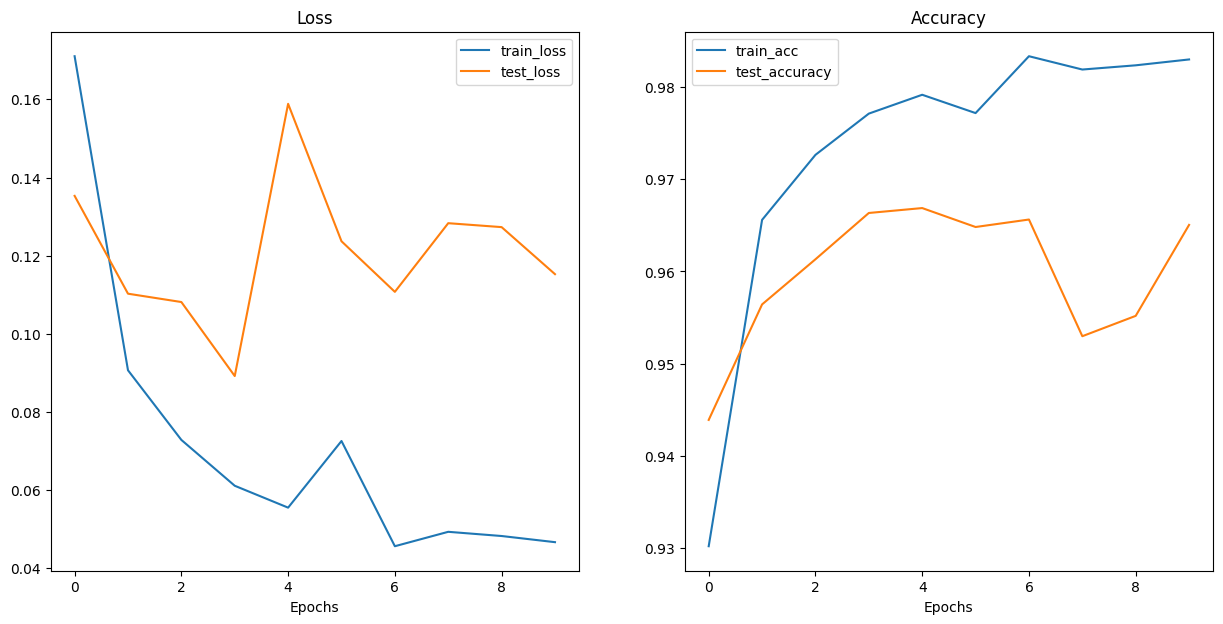

In [82]:
plot_loss_curves(vgg16_model_results)

## 4.3 Evaluating the model

In [43]:
def make_predictions(model: nn.Module,
                     data: list,
                     device: torch.device = device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device)

            # Forward pass (model outputs)
            pred_logits = model(sample)

            # GGet prediction probabilities (logits -> probabilities)
            pred_prob = torch.sigmoid(pred_logits.squeeze())

            # Get pred_prob off the GPU
            pred_probs.append(pred_prob.cpu())
    
    # Stack the pre_probs to turn  list into a tensor
    return torch.stack(pred_probs)

In [45]:
import random
# random.seed = 42
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first sample shape
test_samples[0].shape

torch.Size([3, 64, 64])

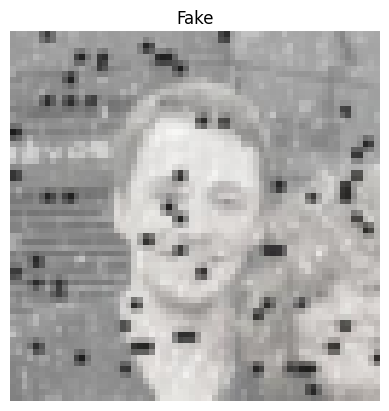

In [62]:
plt.imshow(test_samples[0].permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
plt.show()

In [46]:
# Make predictions
pred_probs = make_predictions(model=vgg16_model,
                              data=test_samples,
                              device=device)

# View the first two prediction probabilities
pred_probs[:2]

tensor([9.6425e-01, 1.9390e-13])

In [47]:
# Convert prediction probabilities to labels
pred_classes = torch.round(pred_probs).type(torch.int)
pred_classes

tensor([1, 0, 0, 0, 0, 0, 0, 1, 0], dtype=torch.int32)

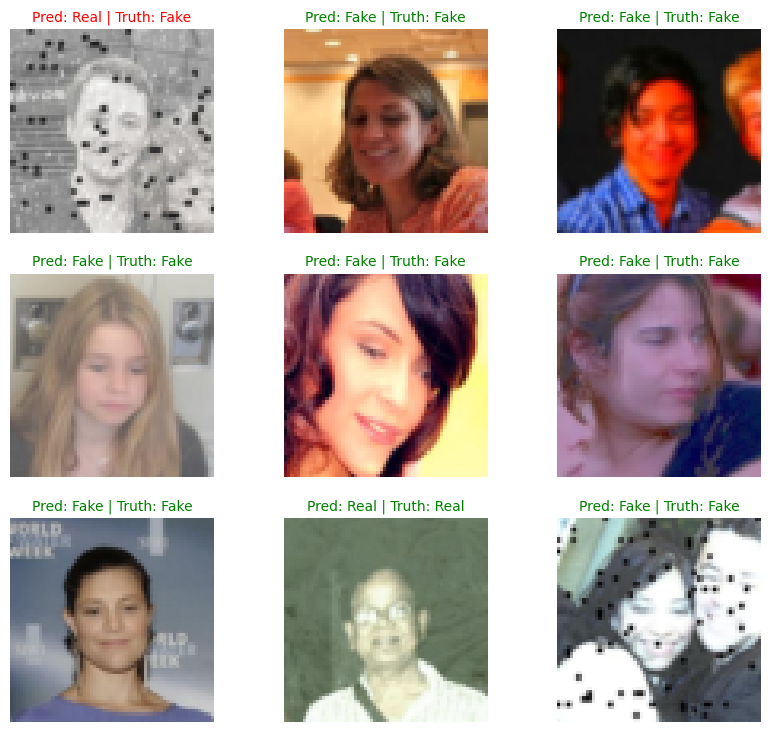

In [48]:
# Plot predictions
plt.figure(figsize=(10, 9))
nrows, ncols = 3, 3
for i, sample in enumerate(test_samples):
    # Create a subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the image
    plt.imshow(sample.permute(1, 2, 0))

    # Find the prediction label
    pred_label = class_names[pred_classes[i]]

    # Find the truth label
    truth_label = class_names[test_labels[i]]

    # Create a title for the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality between pred and truth and change color of title text
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c='g')
    else:
        plt.title(title_text, fontsize=10, c='r')

    plt.axis(False)

In [49]:
# 1. Make predictions with trained model
y_preds = []
vgg16_model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions..."):
        # Send the data to target device
        X, y = X.to(device), y.to(device)
        # Do forward pas
        y_logits = vgg16_model(X).squeeze(dim=1)
        # Turn from logits -> probs -> labels
        y_pred = torch.sigmoid(y_logits)
        # Put predictions on CPU
        y_preds.append(y_pred.cpu())

# print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10]

Making predictions...: 100%|██████████| 341/341 [00:10<00:00, 33.66it/s]


tensor([4.8386e-21, 2.8412e-08, 2.6623e-13, 6.0512e-01, 3.8478e-12, 4.6452e-10,
        5.7075e-09, 8.7431e-22, 4.3245e-01, 5.7342e-08])

In [50]:
# 2. Setup confusion matrix instance and compare predictions to targets
confmat = BinaryConfusionMatrix()
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=torch.Tensor(test_data.targets))

In [52]:
def plot_confusion_matrix(y_true, y_pred, figsize=(8, 6)):
    """
    Create and plot a confusion matrix using seaborn.
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    figsize : tuple, optional
        Figure size for the plot (width, height)
    """
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create figure and axes
    plt.figure(figsize=figsize)
    
    # Create heatmap using seaborn
    sns.heatmap(cm, 
                annot=True,              # Show numbers in cells
                fmt='d',                 # Format as integers
                cmap='Blues',            # Blue color scheme
                cbar=True,              # Show color bar
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    
    # Add labels
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    
    # Return the figure for further customization if needed
    return plt.gcf()

In [55]:
confmat = BinaryConfusionMatrix()
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=torch.Tensor(test_data.targets))

In [57]:
confmat_tensor

tensor([[5243,  249],
        [ 489, 4924]])

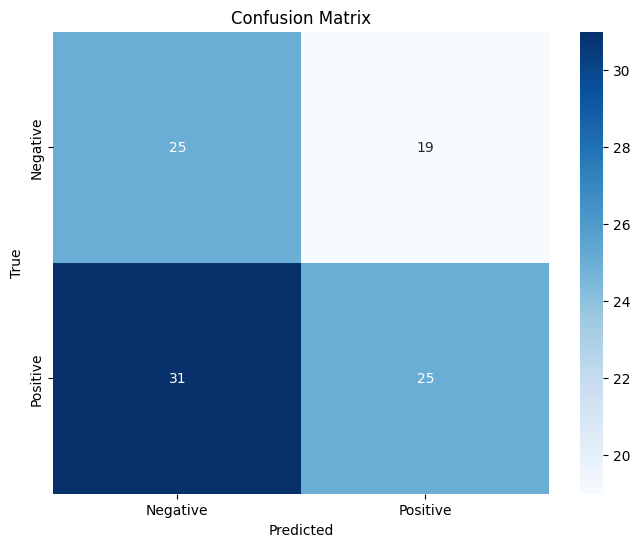

In [65]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate sample data
np.random.seed(42)
y_true = np.random.randint(0, 2, 100)  # Generate 100 random true labels (0 or 1)
y_pred = np.random.randint(0, 2, 100)  # Generate 100 random predictions (0 or 1)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create figure and axes
plt.figure(figsize=(8, 6))

# Create heatmap
sns.heatmap(cm, 
            annot=True,              # Show numbers in cells
            fmt='d',                 # Format as integers
            cmap='Blues',            # Blue color scheme
            cbar=True,              # Show color bar
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])

# Add labels
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

## 4.4 Plot Evaluation metrics through epochs

In [77]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

def print_metrics(y_true, y_pred):
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    print(f"\nIndividual Metrics:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.3f}")
    print(f"Precision: {precision_score(y_true, y_pred):.3f}")
    print(f"Recall: {recall_score(y_true, y_pred):.3f}")
    print(f"F1-score: {f1_score(y_true, y_pred):.3f}")

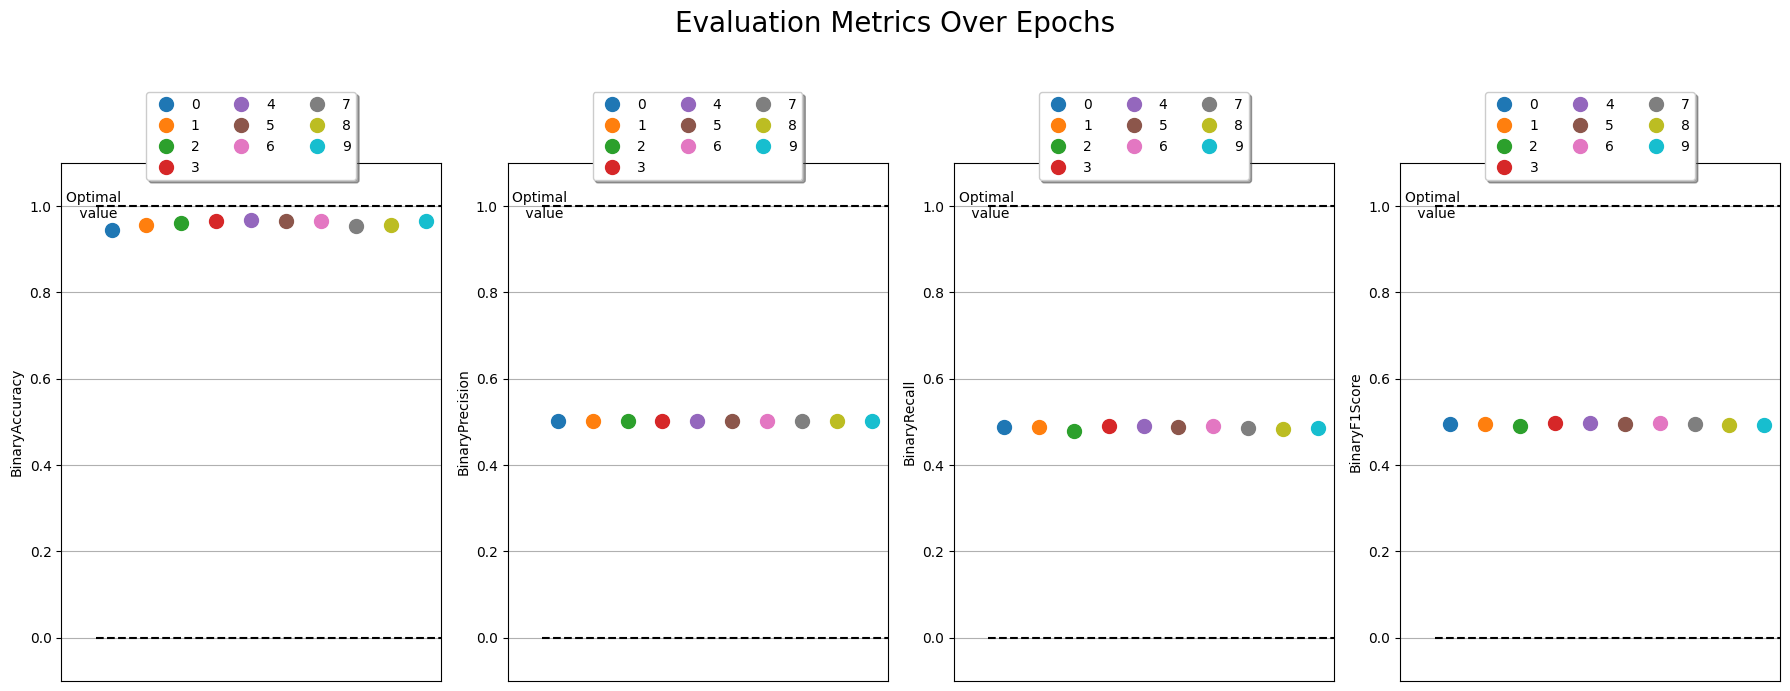

In [74]:
plot_evaluation_metrics(vgg16_model_results)